I am building my own LLM so first I am building a tokenizer of my own

STEP 1 - CREATE THE TOKENS

In [ ]:
with open("01 Harry Potter and the Sorcerers Stone.txt", "r", encoding="Utf-8") as f:
    raw_text = f.read()

print(len(raw_text)) #Total number of characters
print(raw_text[:99])

439478
M r. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly nor


In [ ]:
import re  #library for splitting
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30]) # Remember this is a list having all the tokens

['M', 'r', '.', 'and', 'Mrs', '.', 'Dursley', ',', 'of', 'number', 'four', ',', 'Privet', 'Drive', ',', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', ',', 'thank', 'you', 'very', 'much', '.']


STEP 2 - CREATE TOKEN ID FOR THIS TOKENS

In [ ]:
#now we have to use vocabulary that is the sorted words
words = sorted(set(preprocessed))
vocab_size = len(words)
print(vocab_size)

7572


In [ ]:
#Remember vocab is a mapping from tokens to tokenIDs
vocab = {token:integer for integer, token in enumerate(words)}

In [ ]:
#enumerate - this I have used to assign integer values to the sorted words
for i, item in enumerate(vocab.items()):
    print(item)
    if i>=50:
        break

('!', 0)
("'", 1)
('(', 2)
(')', 3)
('*', 4)
(',', 5)
('-', 6)
('-bodied', 7)
('.', 8)
('1', 9)
('1473', 10)
('1637', 11)
('17', 12)
('1709', 13)
('1945', 14)
('2', 15)
('3', 16)
('31', 17)
('382', 18)
('4', 19)
(':', 20)
(';', 21)
('?', 22)
('A', 23)
('ALBUS', 24)
('ALLEY', 25)
('ALLOWED', 26)
('AM', 27)
('AND', 28)
('ANYTHING', 29)
('ARE', 30)
('AT', 31)
('About', 32)
('According', 33)
('Adalbert', 34)
('Add', 35)
('Adrian', 36)
('Africa', 37)
('African', 38)
('After', 39)
('Against', 40)
('Ages', 41)
('Agrippa', 42)
('Ah', 43)
('Ahead', 44)
('Alberic', 45)
('Albus', 46)
('Albus…”', 47)
('Algie', 48)
('Alicia', 49)
('All', 50)


WE NEED TO REMEMBER TWO CONCEPTS i.e. ENCODER AND DECODER

ENCODER -> it will take text as input and give token ID as output

DECODER -> it will take token ID as input and will give text as output

In [ ]:
class SimpleTokenizer:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [ ]:
#Now let us create an object of the above class and check if it is returning the ids or not
tokenizer = SimpleTokenizer(vocab)
text =  """It was on the corner of the street that he noticed"""
ids = tokenizer.encode(text)
print(ids)

[593, 6597, 4470, 6131, 2269, 4452, 6131, 5888, 6126, 3488, 4427]


In [ ]:
tokenizer.decode(ids)

'It was on the corner of the street that he noticed'

So encoder and decoder is perfectly working as expected

NOW WE HAVE COMPLETED A SIMPLE TOKENIZER OF OUR OWN BUT THERE ARE SOME LIMITATIONS. WE CANNOT USE OTHER TEXT OTHER THAN THE ONE IN THE txt file WE USED MEANING IF I WRITE SOME TEXT THERE WILL BE ERROR SO WE NEED SPECIAL CONTEXT TOKENS WHICH IS ALSO USED BY GPT MODELS .

<|endofText|> and <|unk|> -> unknown will be used

In [ ]:
tokens = sorted(list(set(preprocessed)))
tokens.extend(["<|endofText|>", "<|unk|>"])# Here I used extend it will add 2 extra entries see the result it is 7574 but previously it was 7572
vocab = {token:integer for integer, token in enumerate(tokens)}
len(vocab.items())

7574

Let us check

In [ ]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('…Oak', 7569)
('…Then', 7570)
('…”', 7571)
('<|endofText|>', 7572)
('<|unk|>', 7573)


In [ ]:
class AdvancedTokenizer:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self,text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

Now let us try again with some random text

In [ ]:
tokenizer = AdvancedTokenizer(vocab)

text1 = "Hello, my name is Subhranil Mondal"
text2 = "I am from Kolkata."

text = " <|endofText|> ".join((text1,text2))
print(text)

Hello, my name is Subhranil Mondal <|endofText|> I am from Kolkata.


In [ ]:
tokenizer.encode(text)

[7573, 5, 4318, 4332, 3758, 7573, 7573, 7572, 575, 1391, 3164, 7573, 8]

In [ ]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, my name is <|unk|> <|unk|> <|endofText|> I am from <|unk|>.'

See this is a word based tokenizer but GPT uses subword tokenizer so for that we need Byte Pair encoder

In [ ]:
#we will be using the BPE tokenizer which OpenAI uses
! pip3 install tiktoken

In [ ]:
import importlib
import tiktoken

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
#Let us test

text = "Hello, my name is Subhranil Mondal. I am from Kolkata."
integers = tokenizer.encode(text, allowed_special={"<|endofText|>"})
print(integers)

[15496, 11, 616, 1438, 318, 3834, 16848, 346, 27328, 282, 13, 314, 716, 422, 509, 13597, 1045, 13]


In [ ]:
s = tokenizer.decode(integers)
print(s)

Hello, my name is Subhranil Mondal. I am from Kolkata.


Therefore encoder and decoder is working pretty well

Now, we have to create Input-Target pairs
But what is it?
see we need to do self supervised learning kind of unsupervised. The data are not labeled here . LLM will be feed one word and it will predict next one This is what we gonna implement which the GPT does.

In [ ]:
with open("01 Harry Potter and the Sorcerers Stone.txt", "r", encoding="Utf-8") as f:
    raw_text = f.read()

encoded_text = tokenizer.encode(raw_text)
print(len(encoded_text))

124336


In [ ]:
sample = encoded_text[50:]

In [ ]:
conSize = 4 #context size -> length of input sequence
x = sample[:conSize]
y = sample[1:conSize+1]
print(f"x: {x}")
print(f"y: {y}")

x: [11428, 11, 780, 484]
y: [11, 780, 484, 655]


In [ ]:
for i in range(1, conSize+1):
    context = sample[:i]
    desired = sample[i]

    print(context, "->", desired)

[11428] -> 11
[11428, 11] -> 780
[11428, 11, 780] -> 484
[11428, 11, 780, 484] -> 655


Now just decode it

In [ ]:
for i in range(1, conSize+1):
    context = sample[:i]
    desired = sample[i]

    print(tokenizer.decode(context), "->", tokenizer.decode([desired]))

 mysterious -> ,
 mysterious, ->  because
 mysterious, because ->  they
 mysterious, because they ->  just


so now we have to turn tokens into embeddings and implement a data loader as inputs and PyTorch Tensors as target like you can think about multidimensional arrays.

STEP 3 - IMPLEMENT A DATALOADER(WE WILL BE USING PYTORCH)

In [ ]:
! pip3 install torch torchvision torchaudio

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
class GPTDataset(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        # Step 1 - we will tokenize the entire text
        token_ids = tokenizer.encode(txt,allowed_special={"<|endofText|>"})
        # Step 2 - we will use sliding window to chunk the book into overlapping sequences
        for i in range(0, len(token_ids)-max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    # Step 3 - Then return the total no. of rows
    def __len__(self):
        return len(self.input_ids)

    # Step 4 - Return a single row from the datset
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [ ]:
# Now we have to create the data loader
def create_dataloader(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDataset(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)
    return dataloader

Now Let us Test

In [ ]:
with open("01 Harry Potter and the Sorcerers Stone.txt", "r", encoding="Utf-8") as f:
    raw_text = f.read()

In [ ]:
# Now I am gonna convert dataloader into a python iterator to fetch the next entry

import torch
dataloader = create_dataloader(raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)
iter_data = iter(dataloader)
first_batch = next(iter_data)
print(first_batch)

[tensor([[ 44, 374,  13, 290]]), tensor([[ 374,   13,  290, 9074]])]


see as we used stride=1 so it will overlap so doing this will make the model overfit and noisy .Lets see if we use stride=4 and increase batch_size to 8

In [ ]:
dataloader = create_dataloader(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)
iter_data = iter(dataloader)
inputs, targets = next(iter_data)
print("\nInputs:\n", inputs)
print("\nTargets:\n", targets)


Inputs:
 tensor([[   44,   374,    13,   290],
        [ 9074,    13,   360,  1834],
        [ 1636,    11,   286,  1271],
        [ 1440,    11,  4389, 16809],
        [ 9974,    11,   547,  6613],
        [  284,   910,   326,   484],
        [  547,  7138,  3487,    11],
        [ 5875,   345,   845,   881]])

Targets:
 tensor([[  374,    13,   290,  9074],
        [   13,   360,  1834,  1636],
        [   11,   286,  1271,  1440],
        [   11,  4389, 16809,  9974],
        [   11,   547,  6613,   284],
        [  910,   326,   484,   547],
        [ 7138,  3487,    11,  5875],
        [  345,   845,   881,    13]])


batch size = 8 means the input tensors are also 8 rows

Now let us create token or vector embeddings

In [ ]:
input_ids = torch.tensor([2,3,5,1])

FOR SIMPLICITY WE WILL USE VOCAB SIZE 6

In [ ]:
vocab_size = 6
output_dim = 3 # Output dimensions
# Output will be a 6 X 3 matrix
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)
print(embedding_layer(input_ids))

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)
tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


Now see this is just a basic implementation of token embedding but this is not the right way. we meed to have the concept of positional embeddings -> absolute and relative. GPT or any other transfromer uses absolute embeddings

In [ ]:
vocab_size = 50257 #Lets give the actual vocab_size for GPT2
output_dim = 256 #Lets keep it 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [ ]:
#Now let us create the data loader again
max_length = 4
dataloader = create_dataloader(raw_text, batch_size=8, max_length=max_length, stride=max_length, shuffle=False)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [ ]:
print("\nInput IDs:\n", inputs)
print("\nTarget IDs:\n", targets)
print("\nInputs shape:", inputs.shape) # 8 x 4 tensor


Input IDs:
 tensor([[   44,   374,    13,   290],
        [ 9074,    13,   360,  1834],
        [ 1636,    11,   286,  1271],
        [ 1440,    11,  4389, 16809],
        [ 9974,    11,   547,  6613],
        [  284,   910,   326,   484],
        [  547,  7138,  3487,    11],
        [ 5875,   345,   845,   881]])

Target IDs:
 tensor([[  374,    13,   290,  9074],
        [   13,   360,  1834,  1636],
        [   11,   286,  1271,  1440],
        [   11,  4389, 16809,  9974],
        [   11,   547,  6613,   284],
        [  910,   326,   484,   547],
        [ 7138,  3487,    11,  5875],
        [  345,   845,   881,    13]])

Inputs shape: torch.Size([8, 4])


Each token ID is now embedded as a 256- dimensional vector

Now let us create an embedding layer

In [ ]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


In [ ]:
context_length = max_length
# no.of rows = context_length and no.of columns = output_dim
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [ ]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
#Here torch.arange is creating a sequence of numbers from 0 to max_length-1
print(pos_embeddings.shape)

torch.Size([4, 256])


Now let us add the 4x256 dimensional tensor to each 4x256 token embeddings

In [ ]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


Now Let us Implement a Simplified Attention Mechanism

In [ ]:
import torch
# we are choosing a small embedding dimension for now but it can be replicated for higher dimension space as well
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

Just showing the plotting diagram

In [ ]:
! pip3 install matplotlib

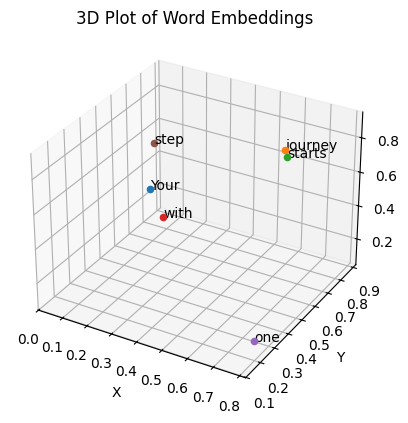

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Corresponding words
words = ['Your', 'journey', 'starts', 'with', 'one', 'step']

# Extract x, y, z coordinates
x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy()

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point and annotate with corresponding word
for x, y, z, word in zip(x_coords, y_coords, z_coords, words):
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, fontsize=10)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Plot of Word Embeddings')
plt.show()

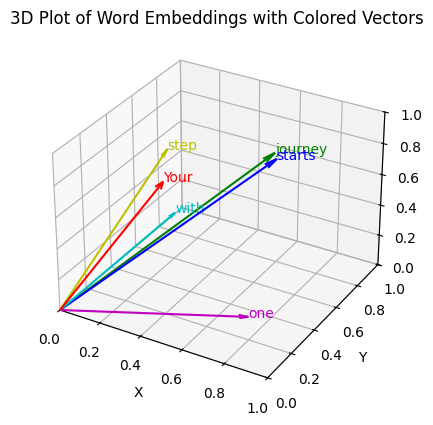

In [ ]:
# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()


In [ ]:
query = inputs[1] #2nd token "journey"
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x, query) # Taking dot product of each word vector with the query vector

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


Now we will implement Normalization to make the LLM stabe

In [ ]:
final_tensor = attn_scores_2 / attn_scores_2.sum()
print(final_tensor)
print("sum:", final_tensor.sum())

tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
sum: tensor(1.0000)


The above approach is not that good so we must use softmax function instead (pytorch)

[e^(x1-max)/sum , e^(x2-max)/sum ,e^(x3-max)/sum  , ...]  

=> [e^(x1-max) + e^(x2-max) + e^(x3-max)+ ...]

In [ ]:
weights = torch.softmax(attn_scores_2, dim=0)
print(weights)
print("sum of weights:", weights.sum())

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
sum of weights: tensor(1.)


Now we need to calculate the context vector which is the enriched embedding vector of journey here as it is query now see this context vector is summation of all other vectors as well .

In [ ]:
query = inputs[1]
context_vector_2 = torch.zeros(query.shape)
for i, x in enumerate(inputs):
    context_vector_2 += weights[i] * x

print(context_vector_2)

tensor([0.4419, 0.6515, 0.5683])


Now let us see visually

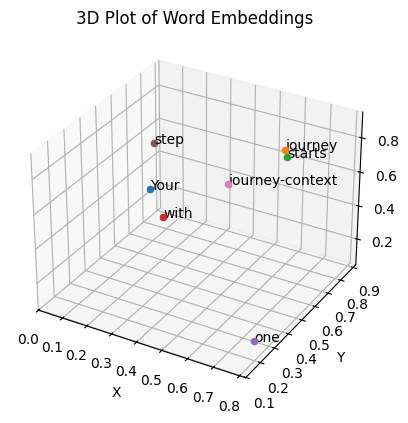

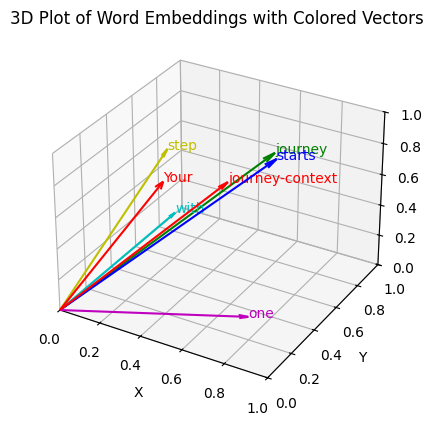

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55], # step     (x^6)
   [0.4419, 0.6515, 0.5683]]
)

# Corresponding words
words = ['Your', 'journey', 'starts', 'with', 'one', 'step', 'journey-context']

# Extract x, y, z coordinates
x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy()

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point and annotate with corresponding word
for x, y, z, word in zip(x_coords, y_coords, z_coords, words):
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, fontsize=10)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Plot of Word Embeddings')
plt.show()

# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'r']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()

Now let us calculate attention weights and context vectors for all inputs

In [ ]:
# I have harcoded this stuff let us do it like this
n = len(inputs)
attn_scores = torch.empty(n,n)
for i, x in enumerate(inputs):
    for j, y in enumerate(inputs):
        attn_scores[i,j] = torch.dot(x,y)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310, 0.7935],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865, 1.1849],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605, 1.1694],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565, 0.6626],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935, 0.5600],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450, 0.8559],
        [0.7935, 1.1849, 1.1694, 0.6626, 0.5600, 0.8559, 0.9427]])


In [ ]:
attn_weights = torch.softmax(attn_scores, dim=1)
print(attn_weights)

tensor([[0.1792, 0.1713, 0.1692, 0.1061, 0.1042, 0.1240, 0.1459],
        [0.1180, 0.2026, 0.1986, 0.1056, 0.0921, 0.1346, 0.1486],
        [0.1184, 0.2017, 0.1981, 0.1058, 0.0943, 0.1332, 0.1485],
        [0.1223, 0.1768, 0.1744, 0.1246, 0.1077, 0.1467, 0.1476],
        [0.1305, 0.1675, 0.1689, 0.1169, 0.1607, 0.1108, 0.1446],
        [0.1180, 0.1861, 0.1813, 0.1211, 0.0842, 0.1615, 0.1478],
        [0.1277, 0.1889, 0.1860, 0.1121, 0.1011, 0.1359, 0.1483]])


In [ ]:
context_vectors = attn_weights @ inputs
print(context_vectors)

tensor([[0.4420, 0.6016, 0.5774],
        [0.4419, 0.6515, 0.5683],
        [0.4429, 0.6499, 0.5673],
        [0.4321, 0.6330, 0.5536],
        [0.4635, 0.5997, 0.5326],
        [0.4213, 0.6505, 0.5651],
        [0.4397, 0.6372, 0.5635]])


Now I wil implement self-attention mechanism previously we did only a simple attention mechanism.

for this we need to dicide the input matrix into thre trainable weight matrices one for query, one for key and another for value.

In [ ]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [ ]:
x_2 = inputs[1] #second input element
d_in = inputs.shape[1] #input embedding size, d=3
d_out = 2 #output embedding size, d_out = 2

In [ ]:
#Let us initialize the three weight matrices Wq, Wk, Wv
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [ ]:
print("W_query:\n", W_query)

W_query:
 Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])


In [ ]:
print(W_key)

Parameter containing:
tensor([[0.1366, 0.1025],
        [0.1841, 0.7264],
        [0.3153, 0.6871]])


In [ ]:
print(W_value)

Parameter containing:
tensor([[0.0756, 0.1966],
        [0.3164, 0.4017],
        [0.1186, 0.8274]])


now we just need to multiply the input vectors with these weight matrices to get the query, key and value vectors

In [ ]:
#But first let us compute the query, key and value vectors for the second input element
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print("query_2:", query_2)  # results in a 2D vector

query_2: tensor([0.4306, 1.4551])


In [ ]:
keys = inputs @ W_key
values = inputs @ W_value
queries = inputs @ W_query
print(keys.shape)
print(values.shape)
print(queries.shape)

torch.Size([6, 2])
torch.Size([6, 2])
torch.Size([6, 2])


Now we have successfully projected the 6 input tokens from a 3D onto a 2D embedding space

Now let us calculate the attention scores

In [ ]:
keys_2 = keys[1] # for the second input element
attn_scores_22 = query_2.dot(keys_2)
print(attn_scores_22)

tensor(1.8524)


In [ ]:
attn_scores_2 = query_2 @ keys.T  # query_2 is 1 X 2 and keys.T is 2 X 6 so the result will be 1 X 6
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


Now let us do it for all queries

In [ ]:
attn_scores = queries @ keys.T
print(attn_scores)

tensor([[0.9231, 1.3545, 1.3241, 0.7910, 0.4032, 1.1330],
        [1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440],
        [1.2544, 1.8284, 1.7877, 1.0654, 0.5508, 1.5238],
        [0.6973, 1.0167, 0.9941, 0.5925, 0.3061, 0.8475],
        [0.6114, 0.8819, 0.8626, 0.5121, 0.2707, 0.7307],
        [0.8995, 1.3165, 1.2871, 0.7682, 0.3937, 1.0996]])


Let us scale the attention scores by dividing them by the sq.root of the keys_dimension

In [ ]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / (d_k**0.5), dim=-1)
print(attn_weights_2)
print(d_k)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])
2


Now we have to calculate the final context vector
context_vec = attention_weights * values

In [ ]:
import torch.nn as nn
class SelfAttention(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / (keys.shape[-1]**0.5), dim=-1)
        context_vectors = attn_weights @ values
        return context_vectors

In [ ]:
torch.manual_seed(123)
self_attn = SelfAttention(d_in, d_out)
print(self_attn(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


Previous approach can be improved using linear instaed of parameter


In [ ]:
class SelfAttention_final_version(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / (keys.shape[-1]**0.5), dim=-1)
        context_vectors = attn_weights @ values
        return context_vectors

In [ ]:
torch.manual_seed(789)
self_attn_v2 = SelfAttention_final_version(d_in, d_out)
print(self_attn_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


In [ ]:
queries = self_attn_v2.W_query(inputs)
keys = self_attn_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


Now let us create a mask where the values above the diagonal are zero

In [ ]:
context_length = attn_scores.shape[0]
mask = torch.tril(torch.ones(context_length, context_length))
print(mask)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


Let us renormalize the weights to sum up to 1

In [ ]:
row_sums = mask.sum(dim=1, keepdim=True)
mask_norm = mask / row_sums
print(mask_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]])


above code may rise to dataleakage instead lets do something efficient

In [ ]:
print(attn_scores)

tensor([[ 0.2899,  0.0716,  0.0760, -0.0138,  0.1344, -0.0511],
        [ 0.4656,  0.1723,  0.1751,  0.0259,  0.1771,  0.0085],
        [ 0.4594,  0.1703,  0.1731,  0.0259,  0.1745,  0.0090],
        [ 0.2642,  0.1024,  0.1036,  0.0186,  0.0973,  0.0122],
        [ 0.2183,  0.0874,  0.0882,  0.0177,  0.0786,  0.0144],
        [ 0.3408,  0.1270,  0.1290,  0.0198,  0.1290,  0.0078]],
       grad_fn=<MmBackward0>)


In [ ]:
maskf = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(maskf.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


Now we need to apply the softmax func to these results

In [ ]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


Now we will implement dropout technique of about 50% for now later we will try to lower this

In [ ]:
torch.manual_seed(123)
dropout = nn.Dropout(0.5)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


This is the casual attention and dropout masking mechanism now lets implement a casuatAttention class

In [ ]:
#Lets create a batch
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) # each token is a 3D embedding vector

torch.Size([2, 6, 3])


In [ ]:
class CasualAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias = False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2)
        attn_scores.masked_fill_(self.mask.bool() [:num_tokens, :num_tokens], -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vectors = attn_weights @ values
        return context_vectors


In [ ]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CasualAttention(d_in, d_out, context_length, 0.0)
context_vectors = ca(batch)
print(context_vectors.shape)

torch.Size([2, 6, 2])


In [ ]:
print(context_vectors)

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)


Lets Implement MultiheadAttention Algorithm

In [ ]:
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CasualAttention(d_in, d_out, context_length, dropout, qkv_bias) for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim = -1)

In [ ]:
torch.manual_seed(123)
context_length = batch.shape[1]
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)
context_vectors = mha(batch)
print(context_vectors)
print(context_vectors.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
torch.Size([2, 6, 4])


Now Let us Implement Multi-Head attention with weight splits which was used to train GPT models

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads) == 0, "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out) #Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        # see we need to interchange between num_heads and head_dim so we need to do transpose also
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1,2)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1,2)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1,2)

        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]#original mask truncated to number of tokens and converted to bool
        #Now let us use the mask to fill attention scores with -inf
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vectors = (attn_weights @ values).transpose(1,2).contiguous().view(b, num_tokens, self.d_out)
        context_vectors = self.out_proj(context_vectors)
        return context_vectors


Now Let's test

In [ ]:
torch.manual_seed(123)
inputs = torch.tensor( # 3 rows 6 columns tensor
  [[0.43, 0.15, 0.89, 0.55, 0.87, 0.66],
   [0.57, 0.85, 0.64, 0.22, 0.58, 0.33],
   [0.77, 0.25, 0.10, 0.05, 0.80, 0.55]],
)

batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) # 2 X 3 X 6 tensor

batch_size, context_length, d_in = batch.shape
d_out = 6
mha = MultiHeadAttention(d_in, d_out, context_length, dropout=0.0, num_heads=2)
context_vectors = mha(batch)
print(context_vectors)
print(context_vectors.shape)

torch.Size([2, 3, 6])
tensor([[[ 0.1569, -0.0873,  0.0210,  0.0215, -0.3243, -0.2518],
         [ 0.1117, -0.0547,  0.0406, -0.0213, -0.3251, -0.2993],
         [ 0.1196, -0.0491,  0.0318, -0.0635, -0.2788, -0.2578]],

        [[ 0.1569, -0.0873,  0.0210,  0.0215, -0.3243, -0.2518],
         [ 0.1117, -0.0547,  0.0406, -0.0213, -0.3251, -0.2993],
         [ 0.1196, -0.0491,  0.0318, -0.0635, -0.2788, -0.2578]]],
       grad_fn=<ViewBackward0>)
torch.Size([2, 3, 6])


see we have used 2 attention heads but GPT 3 used 96 such attention heads which is not possible in my laptop to implement this but the code is extremely powerful

Lets start the actual GPT architecture

In [ ]:
GPT_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

1. Layer Normalizaton

In [ ]:
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
output = layer(batch_example)
print(output)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [ ]:
mean = output.mean(dim=-1, keepdim=True)
var = output.var(dim=-1, keepdim=True)
print(mean)
print(var)

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [ ]:
#Let us apply layer normalization to the layer outputs
output_norm = (output - mean) / torch.sqrt(var)
mean = output_norm.mean(dim=-1, keepdim=True)
var = output_norm.var(dim=-1, keepdim=True)

print(output_norm)
print(mean)
print(var)

tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [ ]:
torch.set_printoptions(sci_mode=False)
print(mean)
print(var)

tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 # to avoid division by zero it is called epsilon
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        normX = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * normX + self.shift

In [ ]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print(mean)
print(var)

tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Lets Implement FeedForward Neural Network with GELU Activation funtion

In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi)) * (x+ 0.044715 * torch.pow(x,3)))) # This is a close approximiation

Now let's use the GELU func to implement the small neural network module, FeedForward, that we will be using in the LLM's transformer block

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            #output embedding dimension is 4 times the input embedding dimension
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]), # expansion layer
            GELU(), # Activation function
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"]) # Contraction layer
        )
    def forward(self, x):
        return self.layers(x)

In [ ]:
print(GPT_CONFIG["emb_dim"])

768


In [ ]:
# creating an instance of FeedForward
ff = FeedForward(GPT_CONFIG)
x = torch.rand(2, 3, 768)
fout = ff(x)
print(fout.shape)

torch.Size([2, 3, 768])


In [ ]:
class DNN(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [ ]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = DNN(layer_sizes, use_shortcut=False)

In [ ]:
#let us implement a function that computes the gradients

def gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])
    loss_fn = nn.MSELoss()
    loss = loss_fn(output, target)
    loss.backward()# backward pass

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [ ]:
gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


see we can clearly observe that the gradients are vanishing as we progress from layer 4 to 0 this is the vanishing gradient problem

In [ ]:
torch.manual_seed(123)
model_with_shortcut = DNN(layer_sizes, use_shortcut=True)
gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694108307361603
layers.2.0.weight has gradient mean of 0.3289699852466583
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258541822433472


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        # shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x



In [ ]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG)
out = block(x)
print("Input shape:", x.shape)
print("Output shape:", out.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG)
out = model(batch)
print("Input batch:", batch)
print("Output logits shape:", out.shape)
print(out)

Input batch: tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output logits shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [ ]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape",model.tok_emb.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape torch.Size([50257, 768])


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

163009536


In [ ]:
# lets apply weight tying
total_params_gpt = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Total trainable parameters:{total_params_gpt:,}")

Total trainable parameters:124,412,160


In [ ]:
size = total_params * 4
total_size_mb = size / (1024**2)
print(f"Total model size in MB: {total_size_mb:.2f} MB")

Total model size in MB: 621.83 MB


In [ ]:
def generate_text(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[: , -context_size:] #crop current context if it exceeds the supported context
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        prob = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(prob, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [ ]:
start_context = "Hello, my name"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:",encoded_tensor.shape)

encoded: [15496, 11, 616, 1438]
encoded_tensor.shape: torch.Size([1, 4])


In [ ]:
#now let us keep the model in eval() mode to disable dropout
model.eval()
out = generate_text(
    model=model,
    idx = encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG["context_length"]
)
print(out)
print(len(out[0]))

tensor([[15496,    11,   616,  1438, 35374, 49329, 38361, 30961, 49419, 35254]])
10


Now let us decode

In [ ]:
decoded = tokenizer.decode(out.squeeze(0).tolist())
print(decoded)

Hello, my name KEY Bagg intermittentswick lug brightly


In [ ]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you Aeiman Byeswickattributeometer inspector Normandy freezerigrate


Now I will implement it on a real dataset I will use Geeta

In [ ]:
import os
import urllib.request

file_path = "01 Harry Potter and the Sorcerers Stone.txt"
url = "https://raw.githubusercontent.com/extremecoder-rgb/MyGPT/refs/heads/master/01%20Harry%20Potter%20and%20the%20Sorcerers%20Stone.txt"

if not os.path.exists(file_path):
  with urllib.request.urlopen(url) as response:
    text_data = response.read().decode('utf-8')
  with open(file_path, "w", encoding="utf-8") as file:
    file.write(text_data)
else:
  with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [ ]:
print(text_data[:99])

M r. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly nor


In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(f"Total characters: {total_characters}")
print(f"Total tokens: {total_tokens}")

Total characters: 439478
Total tokens: 124336


In [ ]:
from torch.utils.data import Dataset, DataLoader
class GPTDataset(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        for i in range(0, len(token_ids)-max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDataset(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)
    return dataloader

In [ ]:
GPT_CONFIG = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [ ]:
train_ratio = 0.90
split_idx = int(total_tokens * train_ratio)
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)
train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG["context_length"],
    stride=GPT_CONFIG["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0,
)

val_loader = create_dataloader(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG["context_length"],
    stride=GPT_CONFIG["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0,
)

In [ ]:
print("Train loader:")
for x,y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x,y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256])

In [ ]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 31232
Validation tokens: 92928
All tokens: 124160


Lets calculate the cross-entropy loss

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss

def calc_loss_loader(dataloader, model, device, num_batches = None):
    total_loss = 0.
    if len(dataloader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len(dataloader))
    for i, (input_batch, target_batch) in enumerate(dataloader):
        if i<num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=3)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=3)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Using device: cuda
Training loss: 11.015273094177246
Validation loss: 11.031612396240234


Now let us implement the training loop for the LLM

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    return train_loss, val_loss

In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
    generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen



In [ ]:
import time
start_time = time.time()
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 3
train_losses, val_losses, tokens_seen = train_model(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.632, Val loss 9.812
Ep 1 (Step 000005): Train loss 7.964, Val loss 7.866
Ep 1 (Step 000010): Train loss 6.840, Val loss 6.900
Ep 1 (Step 000015): Train loss 6.038, Val loss 6.518
Ep 1 (Step 000020): Train loss 5.718, Val loss 6.357
Ep 1 (Step 000025): Train loss 5.923, Val loss 6.263
Ep 1 (Step 000030): Train loss 5.520, Val loss 6.187
Ep 1 (Step 000035): Train loss 5.671, Val loss 6.142
Ep 1 (Step 000040): Train loss 5.383, Val loss 6.033
Ep 1 (Step 000045): Train loss 5.599, Val loss 5.979
Ep 1 (Step 000050): Train loss 5.312, Val loss 5.966
Ep 1 (Step 000055): Train loss 5.221, Val loss 5.964
Ep 1 (Step 000060): Train loss 5.207, Val loss 5.932
Ep 2 (Step 000065): Train loss 5.035, Val loss 5.870
Ep 2 (Step 000070): Train loss 5.068, Val loss 5.886
Ep 2 (Step 000075): Train loss 4.749, Val loss 5.856
Ep 2 (Step 000080): Train loss 4.852, Val loss 5.761
Ep 2 (Step 000085): Train loss 4.778, Val loss 5.729
Ep 2 (Step 000090): Train loss 4.578, Val loss

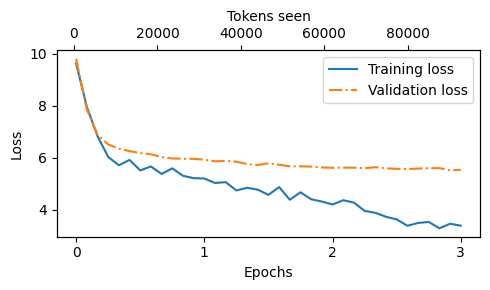

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [ ]:
device = next(model.parameters()).device

token_ids_tensor = text_to_token_ids("Every effort moves you", tokenizer).to(device)

token_ids = generate_text(
    model=model,
    idx=token_ids_tensor,
    max_new_tokens=25,
    context_size=GPT_CONFIG["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves you’s, but it.


“But he was going to the boy,’t, I


Now we can see the model is not generalizing instead it is memorizing

Let us implement Temparature scaling and Top-k sampling

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=1.0, top_k=None, top_p=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)
        if top_p is not None:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
            sorted_indices_to_remove[:, 0] = 0
            indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
            logits = torch.where(indices_to_remove, torch.tensor(float('-inf')).to(logits.device), logits)
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if eos_id is not None and idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)
    return idx


In [ ]:
torch.manual_seed(123)
device = next(model.parameters()).device
input_ids = text_to_token_ids("Every effort moves you", tokenizer).to(device)
token_ids = generate(
    model=model,
    idx=input_ids,
    max_new_tokens=30,
    context_size=GPT_CONFIG["context_length"],
    temperature=1.0,
    top_k=25,
    top_p=0.9,
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you was very to his life.



“What over the wall, but he had had had, as he took a great, and


In [ ]:
model = GPTModel(GPT_CONFIG)
torch.save(model.state_dict(), "model.pth")

In [ ]:
model = GPTModel(GPT_CONFIG)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [ ]:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

LET US LOAD PRETRAINED WEIGHTS FROM OPENAI

In [ ]:
from gpt_download3 import download_and_load_gpt2

In [ ]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 231kiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 559kiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verificati

In [ ]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [ ]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [ ]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG.copy()
NEW_CONFIG.update(model_configs[model_name])


In [ ]:
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])



In [ ]:
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the hand can go until the end of your turn. By now there's a very small delay before you gain


Now let us fine tune it to make it personal assistant

In [ ]:
import json
import os
import urllib
import ssl

def download_and_load_file(file_path, url):
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url, context=ssl_context) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/tatsu-lab/stanford_alpaca/refs/heads/main/alpaca_data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))


Number of entries: 52002


In [ ]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [ ]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Edit the following sentence to make it more concise.

### Input:
He ran to the bus stop in order to catch the bus that was due to arrive in five minutes.

### Response:
He ran to the bus stop, due to arrive in five minutes.


In [ ]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Describe the flavor profile of the following type of cuisine

### Input:
Japanese

### Response:
Japanese cuisine is characterized by its subtle and delicate flavors, featuring a combination of salty, sweet, sour, and umami flavors. It also utilizes fresh ingredients with a focus on preserving their natural flavors.


In [ ]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [ ]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 44201
Validation set length: 2601
Test set length: 5200


In [ ]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [ ]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )

        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [ ]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)


    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()

        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)


tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [ ]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):

    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()

        new_item += [pad_token_id]

        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)


    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [ ]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [ ]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [ ]:
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [ ]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [ ]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Streaming output truncated to the last 5000 lines.
torch.Size([8, 159]) torch.Size([8, 159])
torch.Size([8, 162]) torch.Size([8, 162])
torch.Size([8, 274]) torch.Size([8, 274])
torch.Size([8, 151]) torch.Size([8, 151])
torch.Size([8, 217]) torch.Size([8, 217])
torch.Size([8, 143]) torch.Size([8, 143])
torch.Size([8, 150]) torch.Size([8, 150])
torch.Size([8, 154]) torch.Size([8, 154])
torch.Size([8, 99]) torch.Size([8, 99])
torch.Size([8, 140]) torch.Size([8, 140])
torch.Size([8, 215]) torch.Size([8, 215])
torch.Size([8, 205]) torch.Size([8, 205])
torch.Size([8, 166]) torch.Size([8, 166])
torch.Size([8, 107]) torch.Size([8, 107])
torch.Size([8, 137]) torch.Size([8, 137])
torch.Size([8, 209]) torch.Size([8, 209])
torch.Size([8, 113]) torch.Size([8, 113])
torch.Size([8, 174]) torch.Size([8, 174])
torch.Size([8, 197]) torch.Size([8, 197])
torch.Size([8, 166]) torch.Size([8, 166])
torch.Size([8, 136]) torch.Size([8, 136])
torch.Size([8, 118]) torch.Size([8, 118])
torch.Size([8, 222]) torch.

Now let us load the pretrained LLM

In [ ]:
from gpt_download3 import download_and_load_gpt2

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 257kiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 552kiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verificati

In [ ]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Explain how using transitional words help in writing

### Input:
"<noinput>"


In [ ]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [ ]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

will print an empty input box later.

### Output:

Work with javascript on this example to review the generated response.

In short this requires a simple


In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


In [ ]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.267291212081909
Validation loss: 3.4608896255493162


In [ ]:
# In your terminal or notebook cell
! pip install transformers peft datasets accelerate torch

In [1]:
import torch
import time
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model, TaskType

MODEL_NAME = "gpt2-medium"
CHOOSE_MODEL = "gpt2-medium (355M)"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT = 0.05
LORA_TARGET_MODULES = ["c_attn", "c_proj", "c_fc"]
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32
)
model.to(device)
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=LORA_TARGET_MODULES
)
model = get_peft_model(model, peft_config)

print(f"--- LoRA applied to {CHOOSE_MODEL} ---")
model.print_trainable_parameters()
print("---------------------------------------")

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch).logits
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    with torch.no_grad():
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i < num_batches:
                loss = calc_loss_batch(input_batch, target_batch, model, device)
                total_loss += loss.item()
            else:
                break
    return total_loss / num_batches

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1
            if global_step % eval_freq == 0:
                model.eval()
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                model.train()

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 1
eval_freq = 5
eval_iter = 5

start_context = format_input(val_data[0])

print("Starting LoRA Fine-Tuning...")
start_time = time.time()

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=eval_freq, eval_iter=eval_iter,
    start_context=start_context, tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"\nTraining completed in {execution_time_minutes:.2f} minutes.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

--- LoRA applied to gpt2-medium (355M) ---
trainable params: 3,145,728 || all params: 357,968,896 || trainable%: 0.8788
---------------------------------------


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


NameError: name 'format_input' is not defined

I cannot train this model on this data because of low computational power but all the above code are working